In [89]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    #print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.utils import io

with io.capture_output() as captured:
    print('no prints in here')

import time

In [90]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('Fashion-MNIST', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [91]:
#X, y = mnist["data"], mnist["target"]
#X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]
y = y.astype(np.uint8)

X_train_full, X_test, y_train_full, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train, X_validate, y_train, y_validate = train_test_split(X_train_full, y_train_full)

In [92]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

we can see that to preserve 95% varience we got a reduction from 786 features down to 187,

with is nice, but even with 10 features we get 71% of the varience, 

and more then 86% with 50 features.

In [93]:
pca.n_components_

np.sum(pca.explained_variance_ratio_[:10])
np.sum(pca.explained_variance_ratio_[:50])

187

0.7200606766115962

0.8628205451281368

In [94]:
pca = PCA(n_components = 0.9)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [95]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

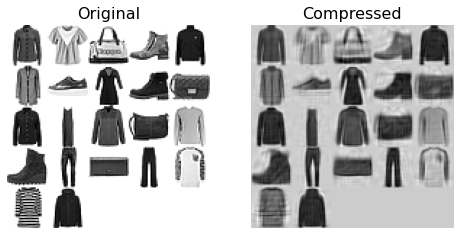

In [96]:
with io.capture_output() as captured:
    plt.figure(figsize=(8, 6))
    plt.subplot(121)
    plot_digits(X_train[::2100])
    plt.title("Original", fontsize=16)
    plt.subplot(122)
    plot_digits(X_recovered[::2100])
    plt.title("Compressed", fontsize=16)

So the idea looks like this, we would find the best models that are different, and would have a different type of error,

and combine them in an ensembler, to boost our succsess rate.

so now lets test different models and select the best models we can.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

best_n_componenets = -1
best_score = 0
for i in [10, 20, 30, 50, 70, 0.8, 0.85, 0.9]:
    model_test = Pipeline([
        ("pca", PCA(n_components = i)),
        ("log_reg", LogisticRegression())
    ])
    start = time.process_time()
    test_val = cross_val_score(model_test, X_train, y_train, cv=3)
    print("cross_val_score :",test_val.mean(), "| pca_componenets : ", i, "| time : ", time.process_time() - start)
    if(test_val.mean() > best_score):
        best_n_componenets = i
        best_score = test_val.mean()
best_n_componenets
best_score

cross_val_score : 0.7547333333333333 | pca_componenets :  10 | time :  55.5625
cross_val_score : 0.8053333333333333 | pca_componenets :  20 | time :  59.359375
cross_val_score : 0.8188444444444444 | pca_componenets :  30 | time :  62.84375
cross_val_score : 0.8357777777777778 | pca_componenets :  50 | time :  68.421875
cross_val_score : 0.8398444444444445 | pca_componenets :  70 | time :  75.984375
cross_val_score : 0.8124444444444444 | pca_componenets :  0.8 | time :  95.671875
cross_val_score : 0.8312222222222222 | pca_componenets :  0.85 | time :  100.6875
cross_val_score : 0.8432666666666666 | pca_componenets :  0.9 | time :  104.921875


0.9

0.8432666666666666

In [10]:
model_log_reg = Pipeline([
        ("pca", PCA(n_components = 50)),
        ("log_reg", LogisticRegression())
    ])

we can see that for the LogisticRegression model, the higher the varience the better the result,

but it cost us much more time to compute and we gain about 0.5% performance from 50 to 70 features,

so a good place to stop would be at about 50 features.

Lets try using kmeans, and see if we get a better result

in my first trial i found out that anything higher then 20 has very low shilluete score.

the highest being 5 clusters

about 5-20 is probably the best range

from more testing concluded that low K-clusters doesnt add value at all!
in fact with more cluster we get better result

In [11]:
ppca = PCA(0.90)
X_train_pca = ppca.fit_transform(X_train)
X_valid_pca = ppca.transform(X_test)

lets compute 4-30 by jumps of 3

In [12]:
from sklearn.cluster import KMeans

k_range = range(4, 30, 3)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=4
k=7
k=10
k=13
k=16
k=19
k=22
k=25
k=28


<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

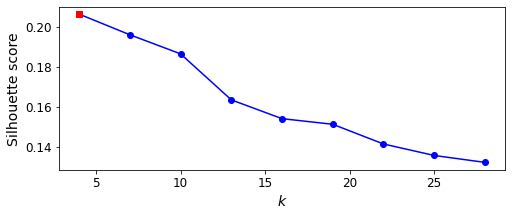

In [13]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [14]:
best_k

4

lets see the inertias, clearly k clusters is too little

<Figure size 576x252 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Inertia')

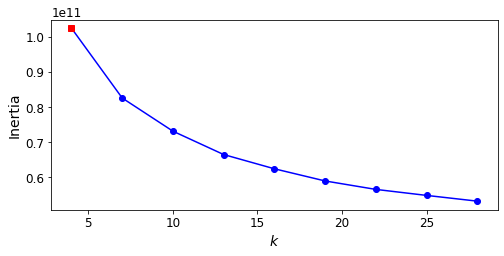

In [15]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

looks like we have elbow at about 15 or so, 20 is also good.

Lets try using log_reg with kmeans, while pca would be 50.

In [16]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

best_pca_n = -1
best_score = 0
best_k = -1
for k in range(10, 30, 3):
    for i in [30, 50]:
        model_test  = Pipeline([
            ("pca", PCA(n_components=i)),
            ("kmeans", KMeans(n_clusters=k)),
            ("log_reg", LogisticRegression()),
        ])
        start = time.process_time()
        test_val = cross_val_score(model_test, X_train, y_train, cv=3)
        print("cross_val_score :",test_val.mean(), "| pca_componenets : ", i, " | k-clusters : ", k
            ,"| time : ", time.process_time() - start)
        if(test_val.mean() > best_score):
            best_k = k
            best_pca_n = i
            best_score = test_val.mean()
best_k
best_pca_n

cross_val_score : 0.7001333333333334 | pca_componenets :  30  | k-clusters :  10 | time :  99.5625
cross_val_score : 0.7008222222222223 | pca_componenets :  50  | k-clusters :  10 | time :  111.796875
cross_val_score : 0.7217555555555556 | pca_componenets :  30  | k-clusters :  13 | time :  106.53125
cross_val_score : 0.7252222222222221 | pca_componenets :  50  | k-clusters :  13 | time :  130.734375
cross_val_score : 0.7370222222222221 | pca_componenets :  30  | k-clusters :  16 | time :  130.0625
cross_val_score : 0.7395333333333333 | pca_componenets :  50  | k-clusters :  16 | time :  152.21875
cross_val_score : 0.7380666666666666 | pca_componenets :  30  | k-clusters :  19 | time :  147.65625
cross_val_score : 0.7396222222222222 | pca_componenets :  50  | k-clusters :  19 | time :  162.25
cross_val_score : 0.7399555555555555 | pca_componenets :  30  | k-clusters :  22 | time :  159.375
cross_val_score : 0.7421333333333333 | pca_componenets :  50  | k-clusters :  22 | time :  192.73

28

50

Okay we can see that using pca=30 and 50 doesnt give much value, and same with k-clusters > 15 

as we get about ~74% accuracity

so lets just take k=15, pca = 30

In [17]:
model_klog  = Pipeline([
            ("pca", PCA(n_components=30)),
            ("kmeans", KMeans(n_clusters=15)),
            ("log_reg", LogisticRegression()),
        ])

In [18]:
start = time.process_time()
test_val = cross_val_score(model_test, X_train, y_train, cv=3)
print("cross_val_score :",test_val.mean(), "| pca_componenets : ", 30, " | k-clusters : ", 15
    ,"| time : ", time.process_time() - start)

cross_val_score : 0.7470666666666667 | pca_componenets :  30  | k-clusters :  15 | time :  242.125


lets try to see if k-means add any value by creating an ensemble model out of it.

and the original log-reg

In [19]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('log_reg', model_log_reg), ('klog', model_klog)],
    voting='soft')
# voting_clf.fit(X_train, y_train)
# voting_clf.score(X_validate, y_validate)

In [20]:
from sklearn.metrics import accuracy_score
for clf in (model_log_reg, model_klog, voting_clf):
    with io.capture_output() as captured:
        clf.fit(X_train, y_train)
    y_pred = clf.predict(X_validate)
    print(clf.__class__.__name__, accuracy_score(y_validate, y_pred))

Pipeline 0.8352666666666667
Pipeline 0.7392666666666666
VotingClassifier 0.82


we can see that not only doesnt out model perform better it even works worse,

with is not stange considering both models are log based.

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate=1)
model_ada = Pipeline([
    ("pca", PCA(n_components = 30)),
    ("ada", ada_clf),
])
#model_ada.fit(X_train, y_train)

adaboost performs terribly, so i will drop the model!

In [22]:
model_ada_scores = cross_val_score(model_ada, X_train, y_train, cv=3)
model_ada_scores.mean()
model_ada_scores

0.5409999999999999

array([0.52966667, 0.55993333, 0.5334    ])

Lets test GaussianNB models

In [23]:
from sklearn.naive_bayes import GaussianNB

best_n_componenets = -1
best_score = 0
for i in [10, 20, 30, 50]:
    for k in [5, 8, 10, 15, 20]:
        model_test = Pipeline([
            ("pca", PCA(n_components = i)),
            ("gnb", GaussianNB()),
        ])
        start = time.process_time()
        test_val = cross_val_score(model_test, X_train, y_train, cv=3)
        print("cross_val_score :",test_val.mean(), "| pca_componenets : ", i, "| time : ", time.process_time() - start)
        if(test_val.mean() > best_score):
            best_n_componenets = i
            best_score = test_val.mean()
best_n_componenets
best_score

cross_val_score : 0.705088888888889 | pca_componenets :  10 | time :  12.421875
cross_val_score : 0.7482444444444445 | pca_componenets :  20 | time :  15.71875
cross_val_score : 0.7699777777777778 | pca_componenets :  30 | time :  17.84375
cross_val_score : 0.7779555555555556 | pca_componenets :  50 | time :  22.8125
cross_val_score : 0.7760000000000001 | pca_componenets :  70 | time :  27.59375
cross_val_score : 0.7587999999999999 | pca_componenets :  0.8 | time :  47.046875
cross_val_score : 0.7768222222222222 | pca_componenets :  0.85 | time :  47.203125
cross_val_score : 0.7722888888888889 | pca_componenets :  0.9 | time :  49.15625


50

0.7779555555555556

Looks like the best params here is pca=50, with a score of 77.77% with is okayish

lets now create our best Gaussian model

In [24]:
from sklearn.naive_bayes import GaussianNB
model_gausiyan = Pipeline([
    ("pca", PCA(n_components = best_n_componenets)),
    ("gnb", GaussianNB()),
])

Lets combine our log model with the gausiyan model

In [25]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('log_reg', model_log_reg), ('gnb', model_gausiyan)],
    voting='soft')

In [26]:
from sklearn.metrics import accuracy_score
for clf in (model_log_reg, model_gausiyan, voting_clf):
    with io.capture_output() as captured:
        clf.fit(X_train, y_train)
    y_pred = clf.predict(X_validate)
    print(clf.__class__.__name__, accuracy_score(y_validate, y_pred))

Pipeline 0.8341333333333333
Pipeline 0.7773333333333333
VotingClassifier 0.8119333333333333


we got even worse performance sadly

Lets mow see the performance of RandomForestClassifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

best_n_componenets = -1
best_score = 0
for i in [10, 20, 30, 50, 70, 0.85, 0.9]:
    model_test = Pipeline([
        ("pca", PCA(n_components = i)),
        ("forest", RandomForestClassifier(n_estimators=50, random_state=42)),
    ])
    start = time.process_time()
    test_val = cross_val_score(model_test, X_train, y_train, cv=3)
    print("cross_val_score :",test_val.mean(), "| pca_componenets : ", i, "| time : ", time.process_time() - start)
    if(test_val.mean() > best_score):
        best_n_componenets = i
        best_score = test_val.mean()
best_n_componenets
best_score

cross_val_score : 0.8193333333333334 | pca_componenets :  10 | time :  29.015625
cross_val_score : 0.8473333333333333 | pca_componenets :  20 | time :  36.609375
cross_val_score : 0.8518 | pca_componenets :  30 | time :  45.046875
cross_val_score : 0.8558222222222223 | pca_componenets :  50 | time :  59.21875
cross_val_score : 0.8557333333333333 | pca_componenets :  70 | time :  71.171875
cross_val_score : 0.8518 | pca_componenets :  0.8 | time :  68.875
cross_val_score : 0.8550888888888889 | pca_componenets :  0.85 | time :  77.265625
cross_val_score : 0.8538444444444444 | pca_componenets :  0.9 | time :  97.015625


50

0.8558222222222223

altough the best classifier would be with pca=70, tbe boost from 30 to 70 isn't that significant, so lets stick to 30-50

lets see if changing the number of estimator's would boost perforamnce.

In [28]:
from sklearn.ensemble import RandomForestClassifier

best_n_componenets = -1
best_score = 0
best_n_estimators = -1
for i in [40, 50, 60]:
    for estimators in [10, 20, 35, 50, 60, 70]:
        model_test = Pipeline([
            ("pca", PCA(n_components = i)),
            ("forest", RandomForestClassifier(n_estimators=estimators, random_state=42)),
        ])
        start = time.process_time()
        test_val = cross_val_score(model_test, X_train, y_train, cv=3)
        print("cross_val_score :",test_val.mean(), "| pca_componenets : ", i, "| n_estimators : ", estimators
            , "| time : ", time.process_time() - start)
        if(test_val.mean() > best_score):
            best_n_componenets = i
            best_score = test_val.mean()
            best_n_estimatos = estimators
best_n_estimatos       
best_n_componenets
best_score

cross_val_score : 0.8018222222222223 | pca_componenets :  10 | n_estimators :  10 | time :  15.40625
cross_val_score : 0.8112 | pca_componenets :  10 | n_estimators :  20 | time :  19.640625
cross_val_score : 0.8172444444444444 | pca_componenets :  10 | n_estimators :  35 | time :  25.0625
cross_val_score : 0.8172 | pca_componenets :  10 | n_estimators :  50 | time :  29.734375
cross_val_score : 0.8203777777777778 | pca_componenets :  10 | n_estimators :  60 | time :  33.5625
cross_val_score : 0.8197111111111112 | pca_componenets :  10 | n_estimators :  70 | time :  37.578125
cross_val_score : 0.8262666666666667 | pca_componenets :  20 | n_estimators :  10 | time :  19.640625
cross_val_score : 0.8403555555555555 | pca_componenets :  20 | n_estimators :  20 | time :  25.0
cross_val_score : 0.8459555555555557 | pca_componenets :  20 | n_estimators :  35 | time :  30.28125
cross_val_score : 0.8470888888888889 | pca_componenets :  20 | n_estimators :  50 | time :  36.59375
cross_val_score 

70

50

0.8580000000000001

we can see that there is little to no difference between the best and medium 50-50  model so lets take this one 

( there is a difference in time tho )

In [29]:
model_forest = Pipeline([
        ("pca", PCA(n_components = 50)),
        ("forest", RandomForestClassifier(n_estimators=50)),
    ])

In [30]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('log_reg', model_log_reg), ('forest', model_forest)],
    voting='soft')

In [31]:
voting_clf.fit(X_train, y_train)
voting_clf.score(X_validate, y_validate)

VotingClassifier(estimators=[('log_reg',
                              Pipeline(steps=[('pca', PCA(n_components=50)),
                                              ('log_reg',
                                               LogisticRegression())])),
                             ('forest',
                              Pipeline(steps=[('pca', PCA(n_components=50)),
                                              ('forest',
                                               RandomForestClassifier(n_estimators=50))]))],
                 voting='soft')

0.8544

well doesnt really help

Lets see if maybe k-mean clustring helps

In [32]:
from sklearn.cluster import KMeans

start = time.process_time()
model_clf = Pipeline([
        ("pca", PCA(n_components = 50)),
        ("kms", KMeans(n_clusters=50)),
        ("forest", RandomForestClassifier(n_estimators=50, random_state=42)),
    ])
model_clf.fit(X_train, y_train)
print(time.process_time() - start)

Pipeline(steps=[('pca', PCA(n_components=50)), ('kms', KMeans(n_clusters=50)),
                ('forest',
                 RandomForestClassifier(n_estimators=50, random_state=42))])

177.265625


In [33]:
model_clf.score(X_validate, y_validate)

0.8044

K-means doesnt help at all, so same fate lets drop it. ( and its really slowing down the process )

and lets for the last part test K-NN model along with PCA,

i have tested a few configurations but for the sake of time iam going to leave only the fastest one

that is when the pca takes only 20 features

In [34]:
from sklearn.ensemble import RandomForestClassifier

ppca = PCA(n_components=20)
X_train_pca = ppca.fit_transform(X_train)
X_valid_pca = ppca.transform(X_validate)

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

start = time.process_time()

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [5, 6, 7]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train_pca, y_train)

print(time.process_time() - start)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=5, weights=uniform ..................................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] ...... n_neighbors=5, weights=uniform, score=0.846, total=   2.4s
[CV] n_neighbors=5, weights=uniform ..................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[CV] ...... n_neighbors=5, weights=uniform, score=0.843, total=   2.5s
[CV] n_neighbors=5, weights=uniform ..................................
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s
[CV] ...... n_neighbors=5, weights=uniform, score=0.844, total=   2.5s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.836, total=   2.4s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.841, tot

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [5, 6, 7],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

65.328125


In [36]:
grid_search.best_params_
grid_search.best_score_

{'n_neighbors': 6, 'weights': 'distance'}

0.8461333333333332

In [37]:
from sklearn.ensemble import RandomForestClassifier

best_n_componenets = -1
best_score = 0
for i in [10, 20, 30, 50, 70, 0.9]:
    model_test = Pipeline([
        ("pca", PCA(n_components = i)),
        ("KNN", KNeighborsClassifier(n_neighbors=6, weights='distance')),
    ])
    start = time.process_time()
    test_val = cross_val_score(model_test, X_train, y_train, cv=3)
    print("cross_val_score :",test_val.mean(), "| pca_componenets : ", i, "| time : ", time.process_time() - start)
    if(test_val.mean() > best_score):
        best_n_componenets = i
        best_score = test_val.mean()
best_n_componenets
best_score

cross_val_score : 0.8107555555555556 | pca_componenets :  10 | time :  15.09375
cross_val_score : 0.8426666666666667 | pca_componenets :  20 | time :  22.234375
cross_val_score : 0.8493555555555555 | pca_componenets :  30 | time :  30.4375
cross_val_score : 0.8527555555555555 | pca_componenets :  50 | time :  51.046875
cross_val_score : 0.8549333333333333 | pca_componenets :  70 | time :  74.796875
cross_val_score : 0.8560444444444445 | pca_componenets :  0.9 | time :  105.234375


0.9

0.8560444444444445

in deed there is not much of a reason for choosing pca>30, as it flatten out at about 85% accuracity at that point

In [38]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_valid_pca)
accuracy_score(y_validate, y_pred)

0.8474

lets create a mew pipeline for the KNN models

In [39]:
model_knn = Pipeline([
        ("pca", PCA(n_components = 50)),
        ("KNN", KNeighborsClassifier(n_neighbors=6, weights='distance')),
    ])

lets combine all the models and see what we've got.

In [40]:
from sklearn.ensemble import VotingClassifier

best_score = 0
mode = 'none'
for i in ['hard', 'soft']:
    voting_clf = VotingClassifier(
        estimators=[('log_reg', model_log_reg), ('forest', model_forest), ("KNN", model_knn)],
        voting = i)
    with io.capture_output() as captured:
        voting_clf.fit(X_train, y_train)
    score = voting_clf.score(X_validate, y_validate)
    print('mode : ', i, " | score :", score)
    if(score > best_score):
        best_score = score
        mode = i
best_score
mode

mode :  hard  | score : 0.8668666666666667
mode :  soft  | score : 0.8704666666666667


0.8704666666666667

'soft'

for the last part lets try SVC with pca = 50

In [73]:
test_val = cross_val_score(model_svc, X_train, y_train, cv=3)
test_val.mean()

0.875688888888889

this looks very promising 87% accuracity!! 

 lets combine it with our final model

In [80]:
final_wsvc_model = VotingClassifier(
        estimators=[('log_reg', model_log_reg), ('forest', model_forest), 
        ("KNN", model_knn), ("svc", model_svc)], voting ='hard')
final_wsvc_model.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg',
                              Pipeline(steps=[('pca', PCA(n_components=50)),
                                              ('log_reg',
                                               LogisticRegression())])),
                             ('forest',
                              Pipeline(steps=[('pca', PCA(n_components=50)),
                                              ('forest',
                                               RandomForestClassifier(n_estimators=50))])),
                             ('KNN',
                              Pipeline(steps=[('pca', PCA(n_components=50)),
                                              ('KNN',
                                               KNeighborsClassifier(n_neighbors=6,
                                                                    weights='distance'))])),
                             ('svc',
                              Pipeline(steps=[('pca', PCA(n_components=50)),
                           

In [81]:
final_wsvc_model.score(X_validate, y_validate)

0.8756666666666667

Combining svc doesnt add anything sadly

In [85]:
final_model = VotingClassifier(
        estimators=[('log_reg', model_log_reg), ('forest', model_forest), 
        ("KNN", model_knn)], voting = 'soft')
final_model.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg',
                              Pipeline(steps=[('pca', PCA(n_components=50)),
                                              ('log_reg',
                                               LogisticRegression())])),
                             ('forest',
                              Pipeline(steps=[('pca', PCA(n_components=50)),
                                              ('forest',
                                               RandomForestClassifier(n_estimators=50))])),
                             ('KNN',
                              Pipeline(steps=[('pca', PCA(n_components=50)),
                                              ('KNN',
                                               KNeighborsClassifier(n_neighbors=6,
                                                                    weights='distance'))]))],
                 voting='soft')

In [86]:
model_svc.score(X_validate, y_validate)
final_model.score(X_validate, y_validate)

0.8688

In [ ]:
model_svc = Pipeline([
        ("pca", PCA(n_components = 50)),
        ("svc", SVC())
    ])
model_svc.fit(X_train, y_train)

In [87]:
model_svc.score(X_test, y_test)
final_model.score(X_test, y_test)

0.8647

So weve got 2 models that give us about ~87% accuracity.

In [83]:
from sklearn.svm import SVC

model_svc = Pipeline([
        ("pca", PCA(n_components = 50)),
        ("svc", SVC())
    ])